In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#Data Manipulation
datos = pd.read_csv("creditcard.csv")
print(datos.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
nr_classes = datos["Class"].value_counts(sort=True)
print(nr_classes)

Class
0    284315
1       492
Name: count, dtype: int64


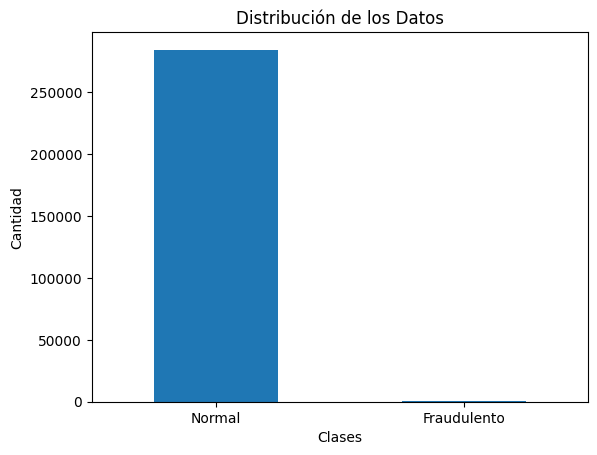

In [3]:
nr_classes.plot(kind="bar", rot=0)
plt.xticks(range(2),["Normal", "Fraudulento"])
plt.title("Distribución de los Datos")
plt.xlabel("Clases")
plt.ylabel("Cantidad")
plt.show()

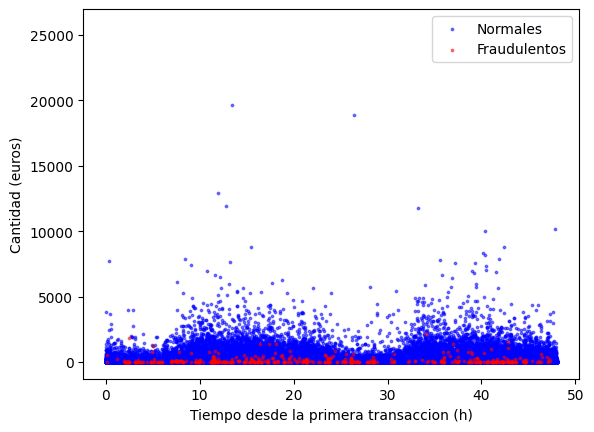

In [5]:
normales=datos[datos.Class==0]
fraudulentos= datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, alpha=0.5, c="blue", label="Normales", s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, alpha= 0.5, c="red", label="Fraudulentos", s=3)
plt.xlabel("Tiempo desde la primera transaccion (h)")
plt.ylabel("Cantidad (euros)")
plt.legend(loc="upper right")
plt.show()

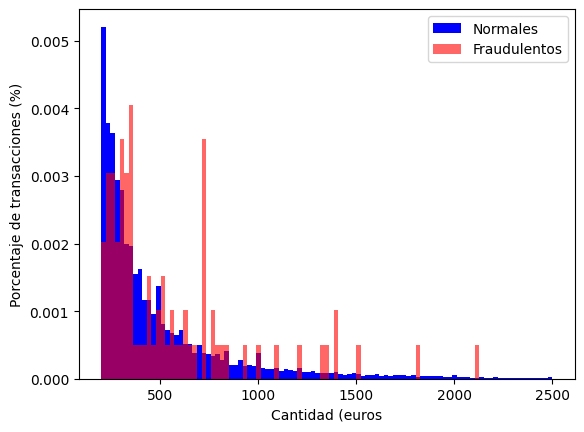

In [7]:
import numpy as np

bins = np.linspace(200,2500,100)
plt.hist(normales.Amount, bins, alpha=1, density= True, label= "Normales", color="blue")
plt.hist(fraudulentos.Amount, bins, alpha=0.6, density=True, label="Fraudulentos", color="red")
plt.legend(loc="upper right")
plt.xlabel("Cantidad (euros")
plt.ylabel("Porcentaje de transacciones (%)")
plt.show()

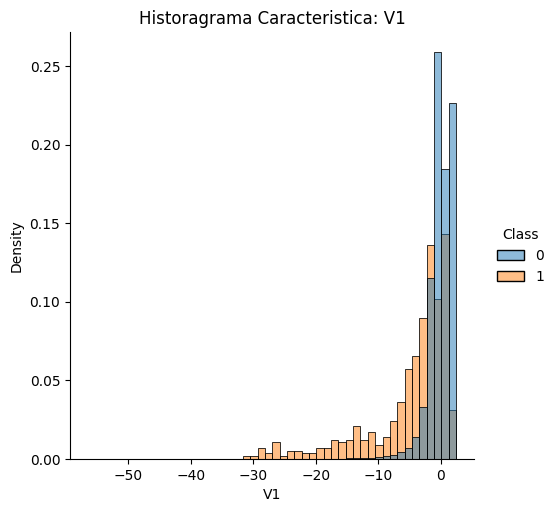

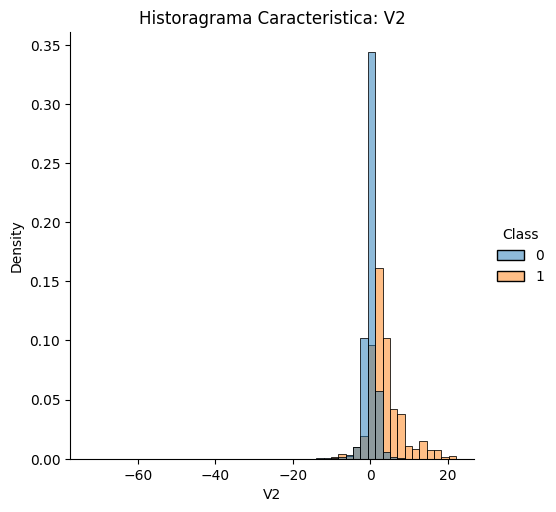

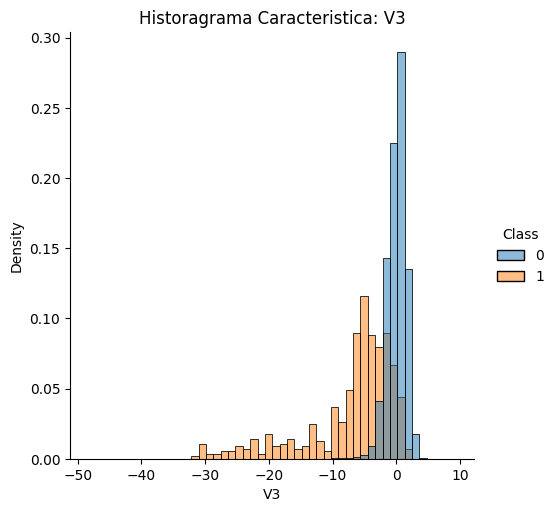

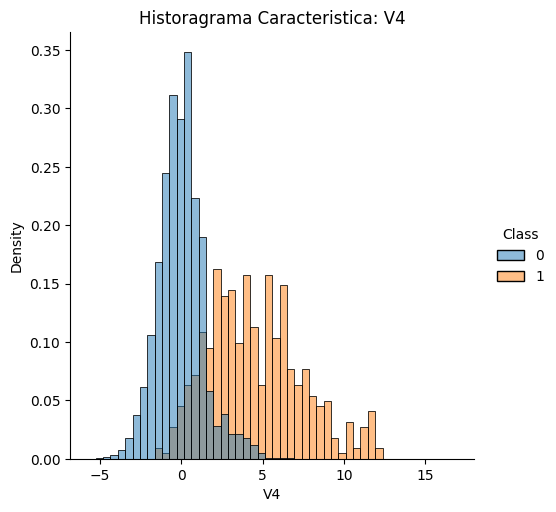

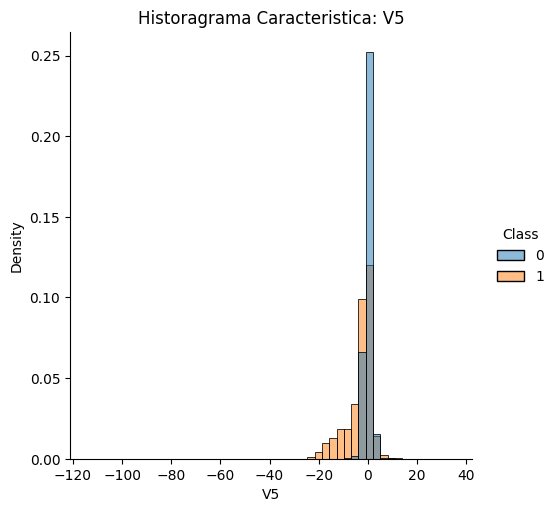

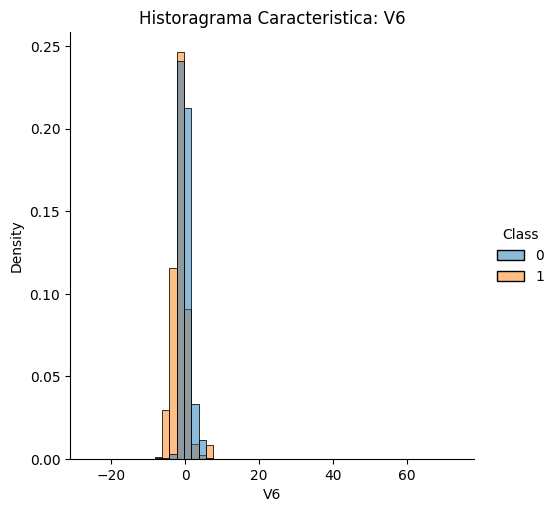

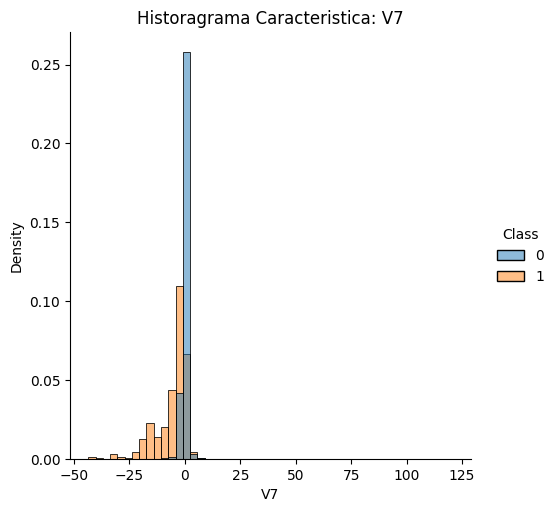

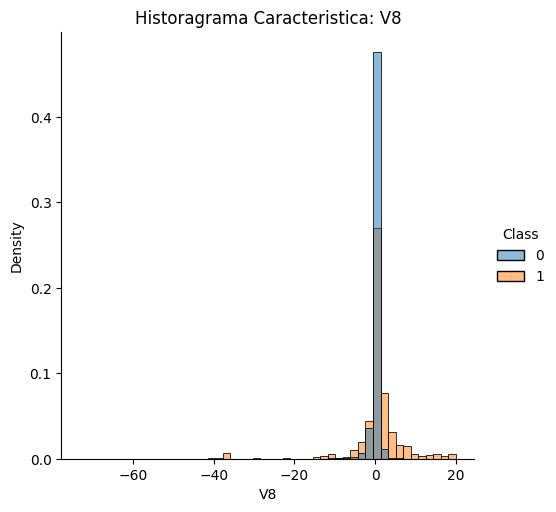

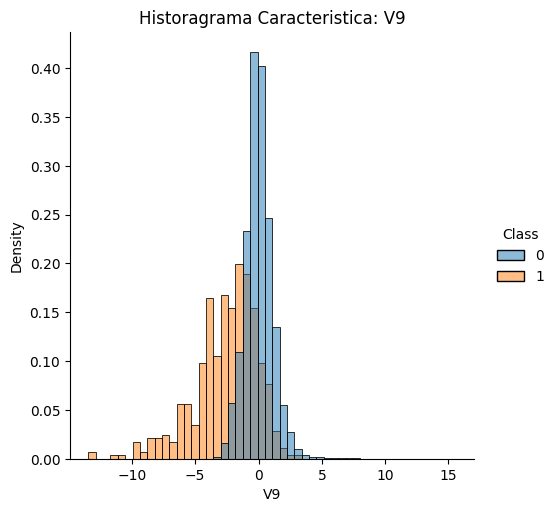

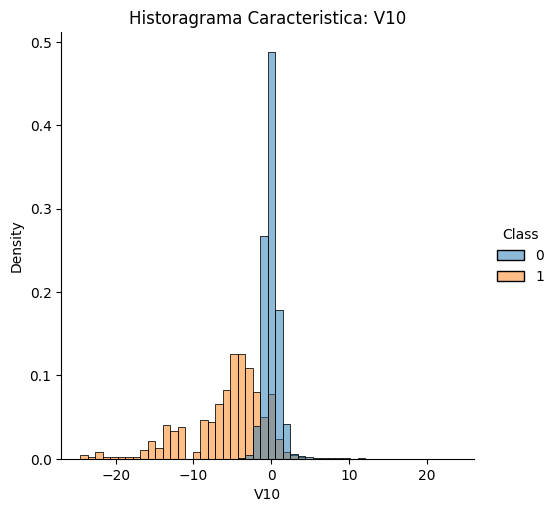

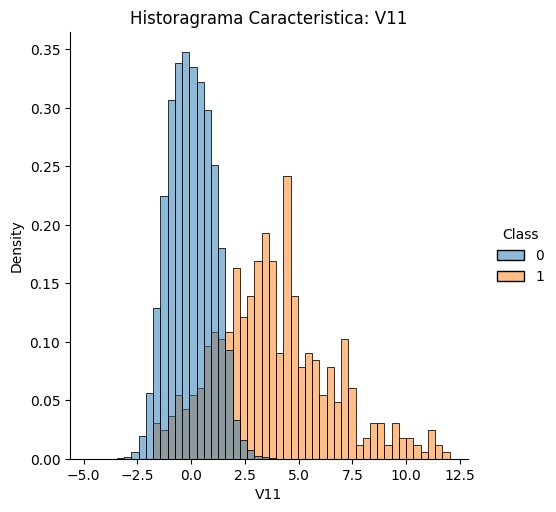

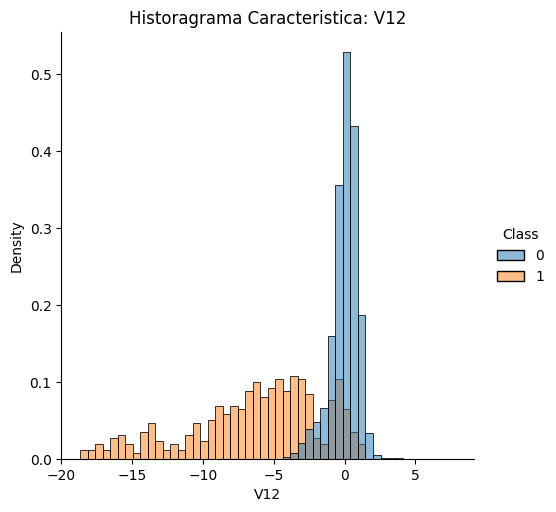

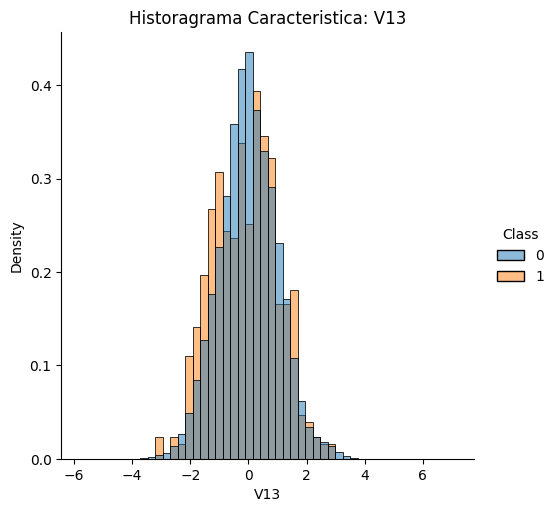

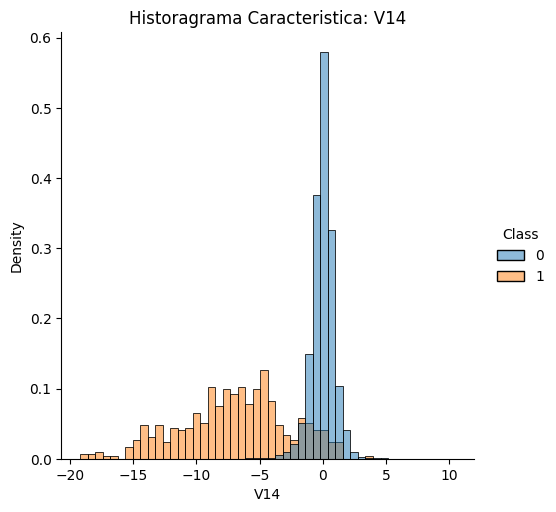

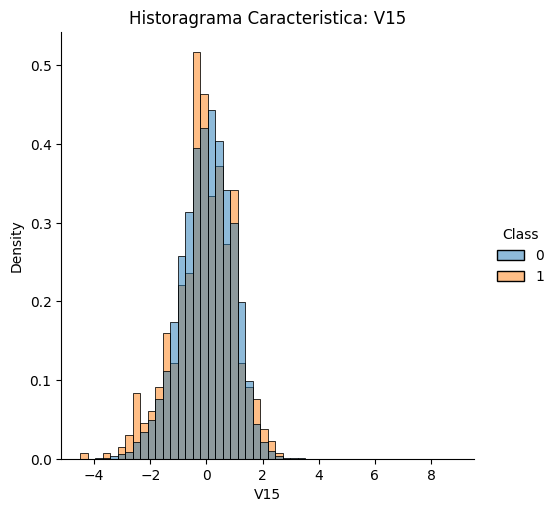

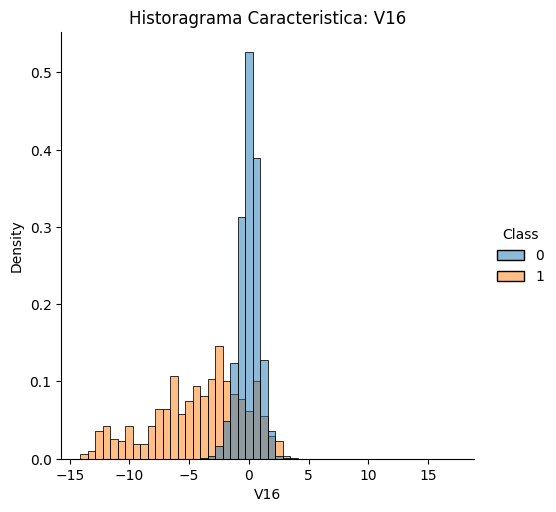

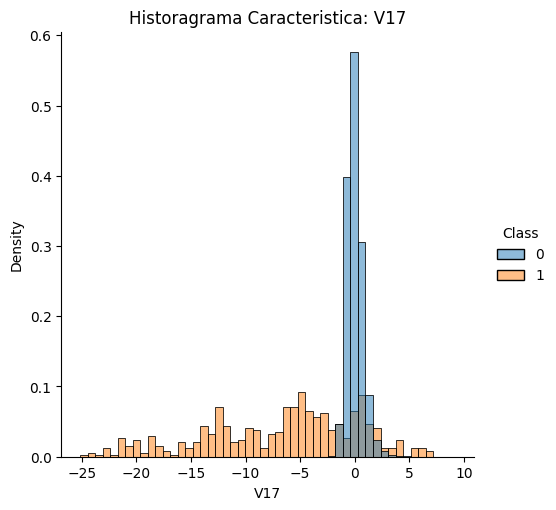

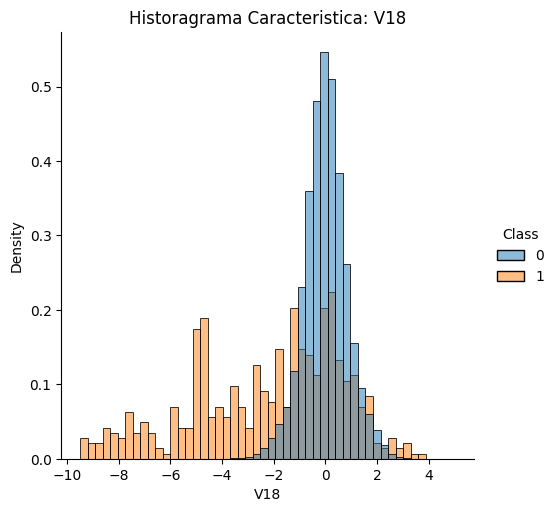

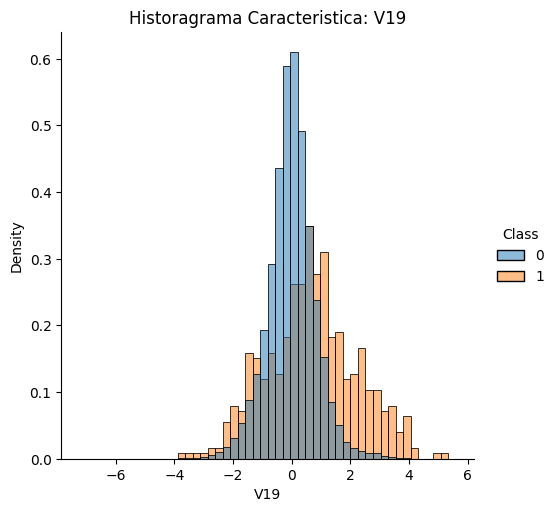

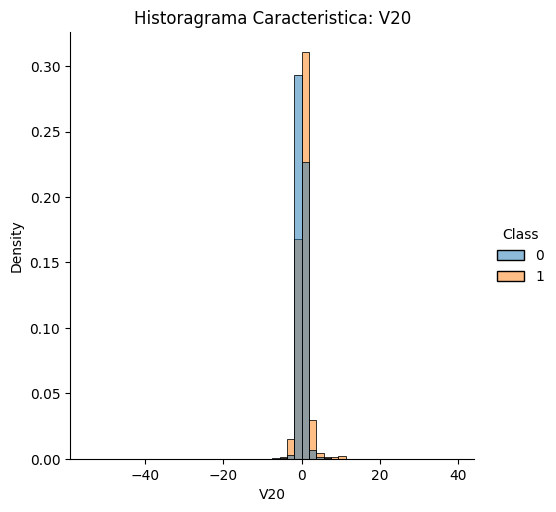

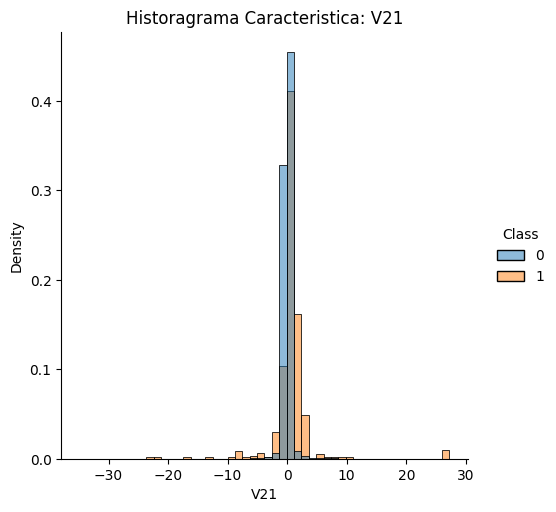

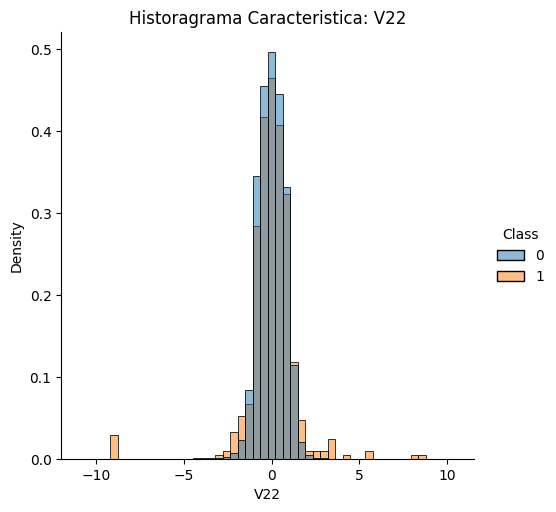

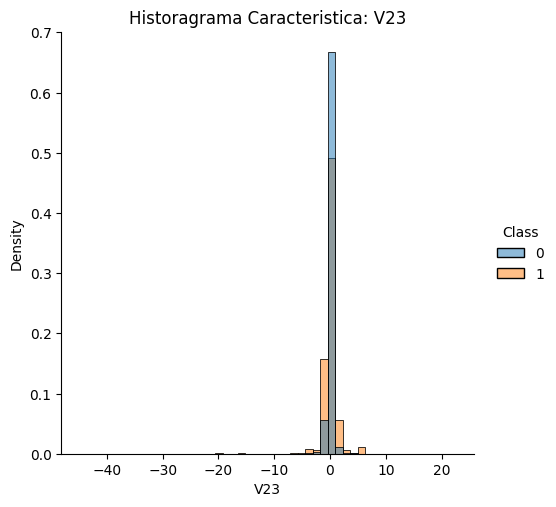

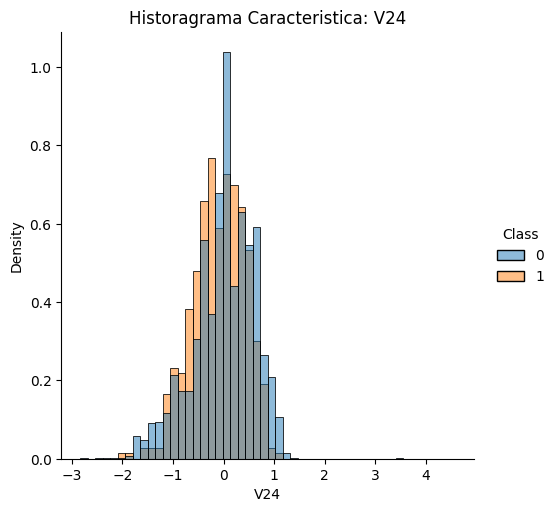

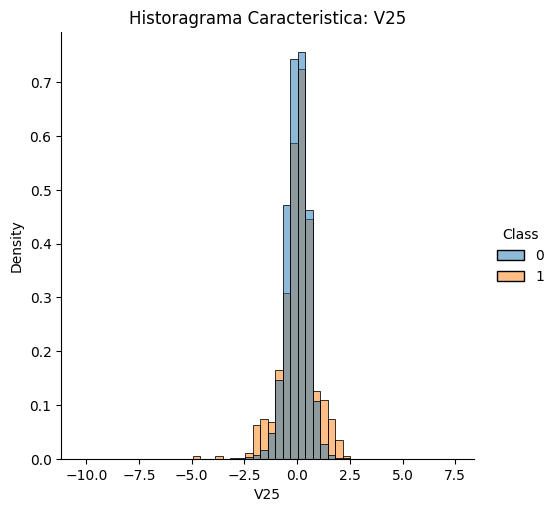

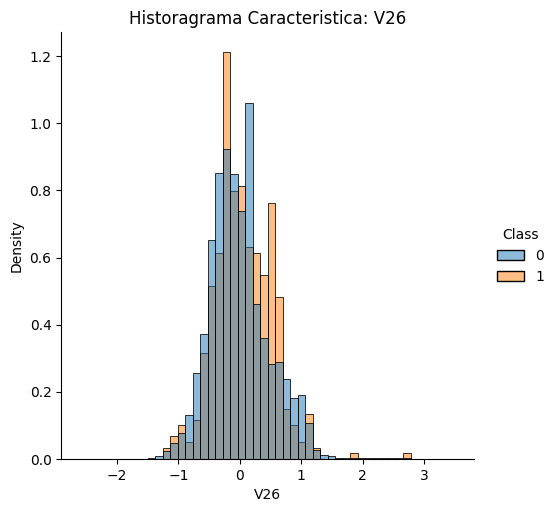

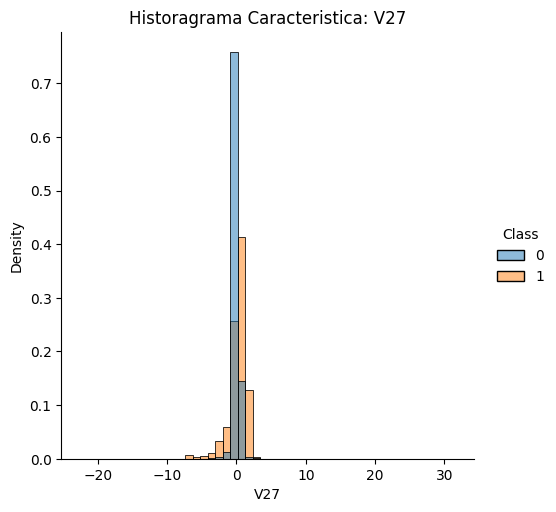

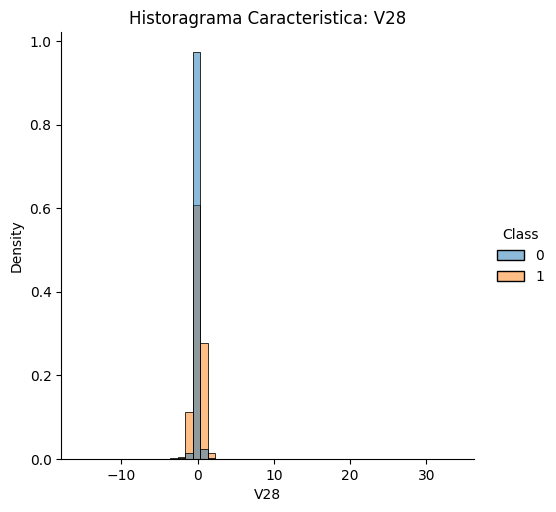

In [31]:
import matplotlib.gridspec as gs
import matplotlib.colors
import seaborn as sns

var = datos.iloc[:,1:29].columns
grid = gs.GridSpec(28,1)
for i, cn in enumerate(datos[var]):
    sns.displot(data = datos, x= cn, hue= "Class", bins=50, stat="density", common_norm=False)
    plt.title("Historagrama Caracteristica: " + str(cn))
    plt.show()

In [32]:
#Procesamiento de Datos

from sklearn.preprocessing import StandardScaler

datos.drop(["Time"], axis=1, inplace=True)
datos["Amount"]=StandardScaler().fit_transform(datos["Amount"].values.reshape(-1,1))

In [33]:
#Train y Test

from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(datos,test_size=0.2, random_state=42)
x_train = x_train[x_train.Class == 0]
x_train = x_train.drop(["Class"], axis=1)
x_train = x_train.values
y_test = x_test["Class"]
x_test = x_test.drop(["Class"], axis = 1)
x_test = x_test.values

In [35]:
np.random.seed(5)

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD

dim_entrada = x_train.shape[1]

capa_entrada = Input(shape=(dim_entrada, ))
encoder = Dense(20, activation="tanh")(capa_entrada)
encoder = Dense(14, activation="relu")(encoder)

decoder = Dense(20, activation="tanh")(encoder)
decoder = Dense(29, activation="relu")(decoder)

autoencoder = Model(inputs= capa_entrada, outputs = decoder)
sgd = SGD(learning_rate=0.01)

#Fit del Modelo
